<a href="https://colab.research.google.com/github/diogopaz/projeto-marvel/blob/1%C2%B0's_insights/projeto_marvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [2]:
!pip install dotenv

In [24]:
import requests
import hashlib
import time
import os
import pandas as pd
from dotenv import load_dotenv
import sqlite3
from google.colab import userdata
from sqlalchemy import text
import matplotlib.pyplot as plt

# Carregando variáveis de ambiente
Estamos fazendo upload do arquivo .env com as chaves de acesso à API no ambeinte de execução do colab.

In [4]:
load_dotenv(dotenv_path='/content/.env')
public_key = os.getenv('MARVEL_PUBLIC_KEY')
private_key = os.getenv('MARVEL_PRIVATE_KEY')

# Montando os parâmetros para realizar a requisição

In [5]:
ts = str(time.time())
to_hash = ts + str(private_key) + str(public_key)
hash_md5 = hashlib.md5(to_hash.encode('utf-8')).hexdigest()

params = {
    'apikey': public_key,
    'ts': ts,
    'hash': hash_md5,
    'limit': 100
}

# Realizando a requisição

In [6]:
url = 'https://gateway.marvel.com/v1/public/characters'

response = requests.get(url, params=params)
data = response.json()
#data

In [7]:
df = pd.DataFrame(data['data']['results'])
df.columns

Index(['id', 'name', 'description', 'modified', 'thumbnail', 'resourceURI',
       'comics', 'series', 'stories', 'events', 'urls'],
      dtype='object')

# Criação da tabela de personagens no banco de dados sqlite

In [8]:
url = 'https://gateway.marvel.com/v1/public/characters'
# >>> Conecta (ou cria) o banco SQLite
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# >>> Cria tabela characters (sem thumbnail/resource_uri)
cursor.execute('''
CREATE TABLE IF NOT EXISTS characters (
    id INTEGER PRIMARY KEY,
    name TEXT,
    description TEXT,
    modified TEXT
)
''')

# >>> Cria tabela character_comics (relacionamento N:N entre personagens e comics)
cursor.execute('''
CREATE TABLE IF NOT EXISTS character_comics (
    character_id INTEGER,
    comic_id INTEGER,
    PRIMARY KEY (character_id, comic_id)
)
''')

conn.commit()

# >>> Função para montar hash exigido pela Marvel
def get_auth_params():
    ts = str(time.time())
    to_hash = ts + private_key + public_key
    hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': hash_md5
    }

# >>> Função para salvar um personagem no banco
def save_character(char):
    cursor.execute('''
    INSERT OR REPLACE INTO characters (id, name, description, modified)
    VALUES (?, ?, ?, ?)
    ''', (
        char['id'],
        char['name'],
        char.get('description', ''),
        char.get('modified', '')
    ))

    # >>> Salva os comics vinculados ao personagem
    for comic in char.get('comics', {}).get('items', []):
        resource_uri = comic.get('resourceURI', '')
        try:
            comic_id = int(resource_uri.strip().split('/')[-1])
            cursor.execute('''
                INSERT OR IGNORE INTO character_comics (character_id, comic_id)
                VALUES (?, ?)
            ''', (char['id'], comic_id))
        except (IndexError, ValueError):
            print(f'❌ Erro ao extrair comic_id de {resource_uri}')

    conn.commit()

# >>> Baixa e salva todos os personagens
def fetch_and_save_characters():
    limit = 100
    offset = 0
    total = 1  # valor fictício inicial

    while offset < total:
        print(f'⏳ Buscando personagens... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f'⚠️ Erro na requisição: {response.status_code}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for char in results:
            save_character(char)

        offset += limit
        time.sleep(0.1)  # respeita limites

    print('✅ Todos os personagens e comics foram salvos no banco!')

# >>> Executa
fetch_and_save_characters()

# >>> Fecha conexão
conn.close()



⏳ Buscando personagens... offset=0
⏳ Buscando personagens... offset=100
⏳ Buscando personagens... offset=200
⏳ Buscando personagens... offset=300
⏳ Buscando personagens... offset=400
⏳ Buscando personagens... offset=500
⏳ Buscando personagens... offset=600
⏳ Buscando personagens... offset=700
⏳ Buscando personagens... offset=800
⏳ Buscando personagens... offset=900
⏳ Buscando personagens... offset=1000
⏳ Buscando personagens... offset=1100
⏳ Buscando personagens... offset=1200
⏳ Buscando personagens... offset=1300
⏳ Buscando personagens... offset=1400
⏳ Buscando personagens... offset=1500
✅ Todos os personagens e comics foram salvos no banco!


In [9]:
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()
cursor.execute('select * from characters')
results_sqlite = cursor.fetchall()
conn.close()
#results_sqlite

In [10]:
conn = sqlite3.connect('marvel.db')
type(results_sqlite)
df_char = pd.read_sql('SELECT * FROM characters', con=conn)
df_char
df_char_comic = pd.read_sql('SELECT * FROM character_comics', con=conn)
df_char_comic

,character_id,comic_id
0,1011334,24571
1,1011334,21366
2,1011334,21546
3,1011334,21741
4,1011334,21975
...,...,...
17557,1009742,37047
17558,1009742,40023
17559,1009742,29541
17560,1009742,75831


In [32]:
query = '''
SELECT character_id, COUNT(*) AS total
FROM character_comics
GROUP BY character_id
ORDER BY total DESC
LIMIT 800
'''

df_char_top_freq = pd.read_sql(query, con=conn)
print(df_char_top_freq)
df_char[df_char['id'] == 1009144]
#df_char[df_char['id'] == 1009146]
#df_char[df_char['id'] == 1009148]

     character_id  total
0         1009144     20
1         1009146     20
2         1009148     20
3         1009150     20
4         1009152     20
..            ...    ...
795       1009543     11
796       1009605     11
797       1009633     11
798       1009660     11
799       1009688     11

[800 rows x 2 columns]


,id,name,description,modified
0,1009144,A.I.M.,AIM is a terrorist organization bent on destro...,2013-10-17 14:41:30+00:00


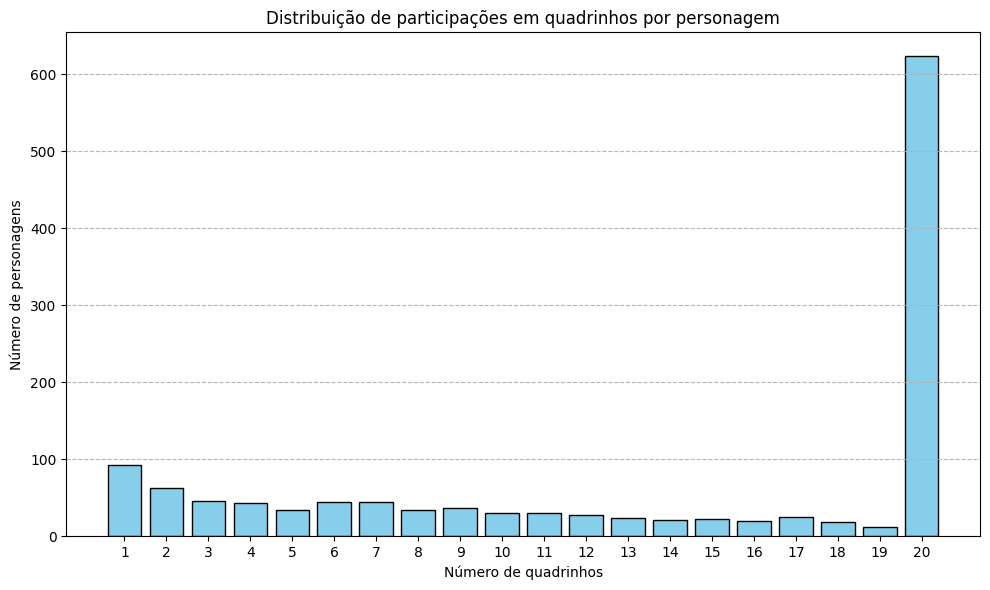

In [41]:
df_counts = df_new['character_id'].value_counts()
counts = df_counts.value_counts().sort_index()  # número de HQs → quantos personagens

plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, width=0.8, color='skyblue', edgecolor='black')
plt.title('Distribuição de participações em quadrinhos por personagem')
plt.xlabel('Número de quadrinhos')
plt.ylabel('Número de personagens')
plt.xticks(counts.index)  # força apenas inteiros no eixo X
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

,count
character_id,
1009148,20
1011515,20
1010354,20
1017851,20
1009144,20


In [39]:
df_char['modified'] = pd.to_datetime(df_char['modified'])
df_antigos = df_char.sort_values('modified')
df_antigos.tail(10)


,id,name,description,modified
1076,1011141,Cerise,,2024-07-24 10:54:55+00:00
1534,1017476,Kitty Pryde (X-Men: Battle of the Atom),,2024-07-24 10:55:25+00:00
531,1009713,Debra Whitman,,2024-07-24 10:55:56+00:00
99,1009250,Countess,,2024-07-24 10:56:39+00:00
1244,1011313,Ender Wiggin,,2024-07-24 10:57:24+00:00
1261,1011330,Revanche,,2024-08-06 15:33:37+00:00
332,1009502,Pretty Boy,,2024-08-06 15:36:21+00:00
1071,1011136,Air-Walker (Gabriel Lan),,2024-09-24 11:11:31+00:00
376,1009550,Bart Rozum,,2024-10-21 15:32:30+00:00
985,1011048,Greycrow (Greycrow),,2025-02-21 12:58:24+00:00
